In [2]:
import os
import numpy as np
import torch
import random
import cv2
import matplotlib.pyplot as plt

In [3]:
CONFIG = {
    "data_path": "/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1",
    "seed": 42,
    "batch_size": 10,
}

In [4]:
random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

In [5]:
from typing import Literal

def get_data_of(root: str, file_type: Literal["RAW", "LANE", "POTHOLE", "CRACK"]):
    all_img = []
    for each in os.listdir(root):
        data_path = os.path.join(root, each)
        if os.path.isdir(data_path):
            for file in os.listdir(data_path):
                if file_type in file:
                    all_img.append(os.path.join(data_path, file))
                    break
    return sorted(all_img)

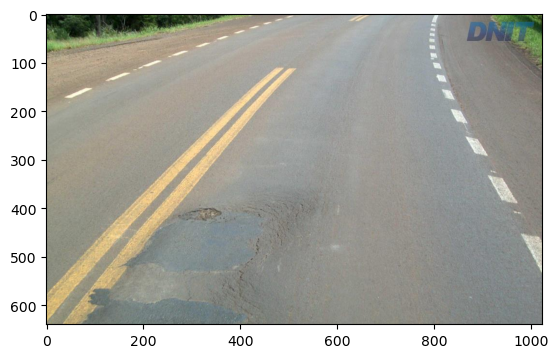

In [6]:
sample = get_data_of(CONFIG["data_path"], "RAW")[4]
sample_img = plt.imread(sample)
plt.imshow(sample_img)

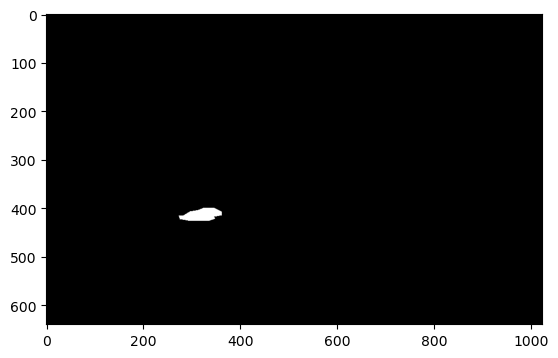

In [7]:
sample = get_data_of(CONFIG["data_path"], "POTHOLE")[4]
sample_img = plt.imread(sample)
plt.imshow(sample_img)

In [8]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class RoadDefectDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(get_data_of(root, "RAW")))
        self.masks = list(sorted(get_data_of(root, "POTHOLE")))

    def __getitem__(self, idx):
        # load images and masks
        # img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(self.imgs[idx])
        mask = read_image(self.masks[idx])
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
from PIL import Image

# --- Custom Dataset for Segmentation ---
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, mask_transform=None):
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_paths = list(sorted(get_data_of(root, "RAW")))
        self.mask_paths = list(sorted(get_data_of(root, "POTHOLE")))
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # For segmentation, masks are often expected as LongTensor for CE loss.
        mask = torch.squeeze(mask).long()  # remove extra channel if needed
        
        return image, mask

In [10]:
dataset = RoadDefectDataset(CONFIG["data_path"])

In [11]:
len(dataset)

2235

In [12]:
dataset1 = SegmentationDataset(CONFIG["data_path"])

In [13]:
len(dataset1)

2235